In [1]:
from base_functions import *

AN example with 4 time steps (N=4) 

In [2]:
### initial parameters

#Those are for spatial domain
up,low,dim = 1.0,-1.0,2
mesh_size,domain_size,bound_size = 50, 1000, 250

#Those are for temporal domain
t0,T,N = 0.0,1.0,4

## Parameters for layers 
#for test 
v_layer,v_hidden_size,v_step = 6,50,1
 #for sol
u_layer,u_hidden_size,u_step = 6,20,2
#?
out_size = 1

#weighted parameter for two loss functions
alpha=25

# training
iteration = 201
n1 = 10
n2 = 10

In [3]:
## time step
t_list=time_grids(t0,T,N)
h=(T-t0)/N
## x value in domain and boundary
# x_domain
x_domain=torch.Tensor(domain_size,dim).uniform_(low,up)

# x_boundary
x_boundary_list=[]  #x_boundry
for i in range(dim):
    x_bound= torch.Tensor(bound_size,dim).uniform_(low,up)
    x_bound[:,i]= up
    x_boundary_list.append(x_bound)
    x_bound= torch.Tensor(bound_size,dim).uniform_(low,up)
    x_bound[:,i]= low
    x_boundary_list.append(x_bound)
x_boundary= torch.cat(x_boundary_list, 0)

# x value for network input
x_mesh=torch.linspace(low,up,mesh_size, requires_grad=True)
mesh1 ,mesh2 = torch.meshgrid(x_mesh,x_mesh)
mesh_1= torch.reshape(mesh1, [-1,1])
mesh_2= torch.reshape(mesh2, [-1,1])
x_test= torch.cat((mesh_1,mesh_2),1)

# integration domain
int_dm = (up-low)**dim 
int_t = (T-t0)

x_test_ = Variable(x_test)
x_test_.requires_grad_(True)
x_boundary_ = Variable(x_boundary)

In [4]:
# define generator and discriminator neural network
class generator(torch.nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.hidden00=torch.nn.Linear(dim, u_hidden_size)
        self.hidden0=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden1=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden2=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden3=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden4=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden5=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden6=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.predict=torch.nn.Linear(u_hidden_size, out_size)
    def forward(self, x):
        x=torch.tanh(self.hidden00(x))
        x=torch.tanh(self.hidden0(x))
        x=F.softplus(self.hidden1(x))
        x=torch.sin(self.hidden2(x))
        x=F.softplus(self.hidden3(x))
        x=torch.sin(self.hidden4(x))
        x=F.softplus(self.hidden5(x))
        x=torch.sin(self.hidden6(x))
        x=self.predict(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.hidden00_v=torch.nn.Linear(dim, v_hidden_size)
        self.hidden0_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden1_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden2_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden3_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden4_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden5_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden6_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.predict_v=torch.nn.Linear(v_hidden_size, out_size)

    def forward(self, x):
        x=torch.tanh(self.hidden00_v(x))
        x=torch.tanh(self.hidden0_v(x))
        x=F.softplus(self.hidden1_v(x))
        x=torch.sin(self.hidden2_v(x))
        x=F.softplus(self.hidden3_v(x))
        x=torch.sin(self.hidden4_v(x))
        x=F.softplus(self.hidden5_v(x))
        x=torch.sin(self.hidden6_v(x))
        x=self.predict_v(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)
 

Current time: tensor(0.2500)
0 tensor(43.0519, grad_fn=<AddBackward0>) tensor(-24.1740, grad_fn=<NegBackward>)
10 tensor(30.2217, grad_fn=<AddBackward0>) tensor(-30.1735, grad_fn=<NegBackward>)
20 tensor(30.9719, grad_fn=<AddBackward0>) tensor(-31.0532, grad_fn=<NegBackward>)
30 tensor(32.7199, grad_fn=<AddBackward0>) tensor(-32.7701, grad_fn=<NegBackward>)
40 tensor(33.6191, grad_fn=<AddBackward0>) tensor(-33.6541, grad_fn=<NegBackward>)
50 tensor(34.2163, grad_fn=<AddBackward0>) tensor(-34.2417, grad_fn=<NegBackward>)
60 tensor(34.6630, grad_fn=<AddBackward0>) tensor(-34.6832, grad_fn=<NegBackward>)
70 tensor(35.0228, grad_fn=<AddBackward0>) tensor(-35.0369, grad_fn=<NegBackward>)
80 tensor(35.2987, grad_fn=<AddBackward0>) tensor(-35.3112, grad_fn=<NegBackward>)
90 tensor(35.5373, grad_fn=<AddBackward0>) tensor(-35.5487, grad_fn=<NegBackward>)
100 tensor(35.7492, grad_fn=<AddBackward0>) tensor(-35.7596, grad_fn=<NegBackward>)
110 tensor(35.9405, grad_fn=<AddBackward0>) tensor(-35.950

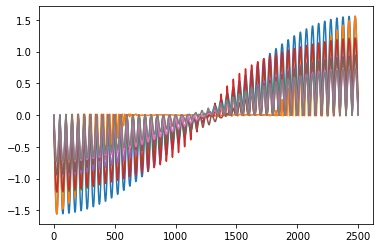

In [5]:
for i in range(N):
    t=t_list[i+1]
    print('Current time:',t)
    # torch variables

    u_test = func_u(x_test,t)
    u_test_ = Variable(u_test)

    # neural network models
    net_u = generator()
    net_v = discriminator()

    # optimizers for grad_u and grad_phi
    optimizer_u_g = torch.optim.SGD(net_u.parameters(), lr = 0)
    optimizer_v_g = torch.optim.SGD(net_v.parameters(), lr = 0)

    # optimizers for WAN
    optimizer_u_o = torch.optim.Adam(net_u.parameters(), lr = 0.015) 
    optimizer_v_o = torch.optim.Adam(net_v.parameters(), lr = 0.015)

    # learning rate decays when loss doesn't change in 10 iterations
    scheduler_u_o = torch.optim.lr_scheduler.StepLR(optimizer_u_o, step_size=700, gamma=0.6, last_epoch=-1) 
    scheduler_v_o = torch.optim.lr_scheduler.StepLR(optimizer_v_o, step_size=700, gamma=0.6, last_epoch=-1)




    prediction_u_o = net_u(x_test_)
    prediction_v_o = net_v(x_test_)

    for nn in range(iteration):
    
        
        for i in range(n1):
            if i==0:
                loss_u = Loss_u_0(optimizer_u_o,x_test,x_test_,prediction_u_o, optimizer_v_o,\
                                  prediction_v_o,h,t,net_u, x_boundary, x_boundary_,alpha)
            else:
                loss_u=Loss_u_1(optimizer_u_o,x_test,x_test_,prediction_u_o, optimizer_v_o,\
                                prediction_v_o,h,t,net_u,x_boundary, x_boundary_,alpha)
                
            optimizer_u_o.zero_grad()
            loss_u.backward(retain_graph=True)
            optimizer_u_o.step()
            scheduler_u_o.step() #loss_u
            prediction_u_o = net_u(x_test_)
        
    
        for j in range(n2):
            if i==0:
                loss_v = Loss_v_0(optimizer_u_o,x_test,x_test_,prediction_u_o,\
                                  optimizer_v_o,prediction_v_o,h,t)
            else:
                loss_v = Loss_v_1(net_u,optimizer_u_o,x_test,x_test_,prediction_u_o,\
                                  optimizer_v_o,prediction_v_o,h,t)
                
            optimizer_v_o.zero_grad()
            loss_v.backward(retain_graph=True)
            optimizer_v_o.step()
            scheduler_v_o.step() #loss_v
            prediction_v_o = net_v(x_test_)
            

        if nn%10==0:
            print(nn, loss_u, loss_v)
#             print('The learning rate at %d th epoch：%f'%(nn, optimizer_u_o.param_groups[0]['lr']))
#             print('The learning rate at %d th epoch：%f'%(nn, optimizer_v_o.param_groups[0]['lr']))
        


true sol and pred sol at the last step

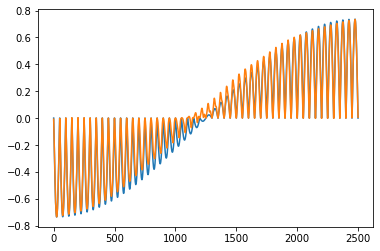

In [6]:
    plt.plot(u_test.data.numpy())
    plt.plot(prediction_u_o.data.numpy())